### import libraries and load file

In [16]:
!pip install transformers==3.0.0

In [146]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
from transformers import BertTokenizer
import torch.nn as nn
import seaborn as sn

In [54]:
df0 = pd.read_csv("labeled_data.csv")
df0.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [55]:
## needs some refactoring...
c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


In [56]:
df.head()

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1


In [57]:
df.groupby('label').count()

,text,category
label,,
0,1430,1430
1,19190,19190
2,4163,4163


# Split Dataset

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

In [58]:
df_temp, df_test = train_test_split(df, test_size = 0.10,
                                     random_state = 42,
                                     stratify=df.label)
# we will use temp_text and temp_labels to create validation and test set
df_train, df_val = train_test_split(df_temp, test_size = 0.1,
                                     random_state = 42,
                                     stratify=df_temp.label)

df_train.shape, df_val.shape, df_test.shape

((20073, 3), (2231, 3), (2479, 3))

In [41]:
import re
def preprocessing(tweet):
    review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
    review = re.sub('RT', ' ', review)
    review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
    review = re.sub(r"https?", " ", review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    return review

In [59]:
df_train['text'] = df_train.text.apply(lambda x: preprocessing(x))

df_val['text'] = df_val.text.apply(lambda x: preprocessing(x))

df_test['text'] = df_test.text.apply(lambda x: preprocessing(x))

df_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,text,category,label
21173,stop being a hoe,offensive_language,1
21589,the nations know who we are but we rather be ...,hate_speech,0
17349,slander don t exist when you make her cum...,offensive_language,1
4290,dishing texas trash talking pts with racist ...,offensive_language,1
4368,one charlotte store but of course they ar...,offensive_language,1
...,...,...,...
15696,you may be redneck if you put steak seaso...,neither,2
23428,you think america has crooked laws women in ot...,offensive_language,1
4908,call me bitch again and see if i don t slap ...,offensive_language,1
2470,who invited this fag,offensive_language,1


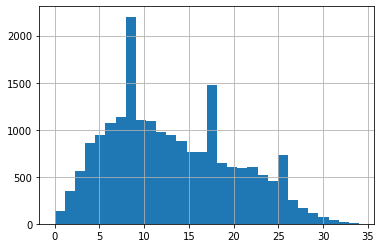

In [61]:
# get length of all the messages in the train set
seq_len = [len(text.split()) for text in df_train.text.values]

pd.Series(seq_len).hist(bins = 30)

# Tokenize

In [43]:
from transformers import BertTokenizerFast
from torch.utils.data import TensorDataset
import torch

In [63]:
max_seq_len = 40

In [64]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [67]:
def tokenize(df):
    return tokenizer.batch_encode_plus(
    df.text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [69]:
# tokenize and encode sequences in the training set
encoded_data_train = tokenize(df_train)

# tokenize and encode sequences in the validation set
encoded_data_val = tokenize(df_val)



In [71]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_val.label.values)



In [72]:
dataset_train = TensorDataset(
    torch.tensor(input_ids_train),
    torch.tensor(attention_masks_train),
    labels_train
)

dataset_val = TensorDataset(
    torch.tensor(input_ids_val),
    torch.tensor(attention_masks_val),
    labels_val
)

# Bert

In [73]:
from transformers import BertForSequenceClassification

In [74]:
label_dict = {'neither': 2, 'offensive_language': 1, 'hate_speech': 0}
label_dict

{'hate_speech': 0, 'neither': 2, 'offensive_language': 1}

In [ ]:
#possible_labels = df.category.unique()
#label_dict = {}
#for index, possible_label in enumerate(possible_labels):
#    label_dict[possible_label] = index
#label_dict = {'neither': 0, 'offensive_language': 1, 'hate_speech': 2}

In [110]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions=False,
    output_hidden_states=False    
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [76]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

### Create Dataloader

In [111]:
batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [112]:
# Optimizer and Scheduler

from transformers import AdamW, get_linear_schedule_with_warmup

In [113]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)
epochs = 2
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [115]:
# Random seed for reproducibility
import random
from tqdm.notebook import tqdm

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [117]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(df_train.label), df_train.label)

print(class_wts)

[5.77806563 0.43048318 1.98428233]


In [118]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [208]:
# Define Metrics
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return balanced_accuracy_score(y_true=labels_flat, y_pred=preds_flat)  

def plot_confusion_matrix(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    cm = confusion_matrix(labels_flat, preds_flat)

    df_cm = pd.DataFrame(cm, range(3), range(3))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.2) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt="d",cmap='Blues') # font size
    plt.show()

def report(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    target_names = ['Hate Speech', 'Off. Language', 'Neither']
    print(classification_report(labels_flat, preds_flat, target_names=target_names))

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [187]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions_val, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        # loss = outputs[0]
        
        logits = outputs[1]
        loss = cross_entropy(logits, batch[2])

        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions_val.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions_val = np.concatenate(predictions_val, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions_val, true_vals

# Train

In [188]:
# epoch loop
#model.load_state_dict(torch.load('./finetuned_BERT2.model', map_location=torch.device('cpu')))
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        logits = outputs[1]
        loss = cross_entropy(logits, batch[2])

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions_val, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions_val, true_vals)
    val_bacc = accuracy(predictions_val, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Balanced Accuracy Score: {val_bacc}')

torch.save(model.state_dict(), f'finetuned_BERT.model')


Epoch 1
Training loss: 0.3872530769888952
Validation loss: 0.3994119622877666
F1 Score (Weighted): 0.8972736815563124
Balanced Accuracy Score: 0.8474333619112171



Epoch 2
Training loss: 0.3876922693174736
Validation loss: 0.4002761649233954
F1 Score (Weighted): 0.8972736815563124
Balanced Accuracy Score: 0.8474333619112171



### Evaluation

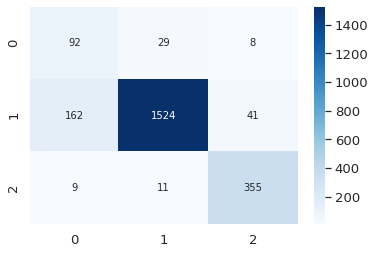

In [209]:
plot_confusion_matrix(predictions_val, true_vals)

In [201]:
accuracy_per_class(predictions_val, true_vals)

Class: hate_speech
Accuracy: 92/129

Class: offensive_language
Accuracy: 1524/1727

Class: neither
Accuracy: 355/375



In [202]:
report(predictions_val, true_vals)

               precision    recall  f1-score   support

  Hate Speech       0.35      0.71      0.47       129
Off. Language       0.97      0.88      0.93      1727
      Neither       0.88      0.95      0.91       375

     accuracy                           0.88      2231
    macro avg       0.73      0.85      0.77      2231
 weighted avg       0.92      0.88      0.90      2231



# Test

In [203]:
# tokenize and encode sequences in the test set
encoded_data_test = tokenize(df_test)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df_test.label.values)

dataset_test = TensorDataset(
    torch.tensor(input_ids_test),
    torch.tensor(attention_masks_test),
    labels_test
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

In [204]:
test_loss, predictions_test, true_test = evaluate(dataloader_test)
test_f1 = f1_score_func(predictions_test, true_test)
test_bacc = accuracy(predictions_test, true_test)
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'F1 Score (Weighted): {test_f1}')
tqdm.write(f'Balanced Accuracy Score: {test_bacc}')


Test loss: 0.42742113062204456
F1 Score (Weighted): 0.8964188754032866
Balanced Accuracy Score: 0.8422688422688421


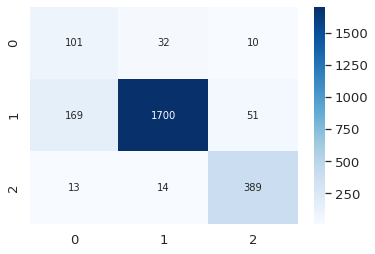

In [210]:
plot_confusion_matrix(predictions_test, true_test)

In [206]:
accuracy_per_class(predictions_test, true_test)

Class: hate_speech
Accuracy: 101/143

Class: offensive_language
Accuracy: 1700/1920

Class: neither
Accuracy: 389/416



In [207]:
report(predictions_test, true_test)

               precision    recall  f1-score   support

  Hate Speech       0.36      0.71      0.47       143
Off. Language       0.97      0.89      0.93      1920
      Neither       0.86      0.94      0.90       416

     accuracy                           0.88      2479
    macro avg       0.73      0.84      0.77      2479
 weighted avg       0.92      0.88      0.90      2479

